In [196]:
from Bio.Align.Applications import ClustalOmegaCommandline
from sklearn.metrics import pairwise_distances
from tcrdist.repertoire import TCRrep
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from polyleven import levenshtein
from collections import Counter
from itertools import product
import logomaker as lm
from Bio import SeqIO
import seaborn as sns
import pandas as pd
import numpy as np
import math
import os 

In [9]:
%load_ext rpy2.ipython
%matplotlib inline

In [197]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [10]:
%%R
library(ggplot2)
library(RColorBrewer)

In [11]:
#import associated clones
#FMBA_TRB_ttest
pool_FMBA=pd.read_csv("/projects/fmba_covid/fmba_new/pool/TRB.pool.aa.table.txt", sep = '\t') 
associated_clones_FMBA=pd.read_csv("../../fmba/FMBA_TRB_sign_clones_ttest_top2000.tsv", sep = '\t', index_col=0)
associated_clones_FMBA=list(associated_clones_FMBA.index.values)
associated_clones_FMBA=list(filter(str.isalpha, associated_clones_FMBA))
associated_clones_FMBA=associated_clones_FMBA[:1000]
print("Top of", len(associated_clones_FMBA))

Top of 1000


In [12]:
#import associated clones
#AB_Fisher
pool_AB=pd.read_csv("/projects/fmba_covid/adaptive_new/pool/pool.aa.table.20+.txt", sep = '\t') 
associated_clones_AB_down = pd.read_csv('../../adaptive/associated_clones_fisher_exact_test.txt', sep='\t')
associated_clones_AB_down = list(associated_clones_AB_down.cdr3aa)[:1000]
print("Top of", len(associated_clones_AB_down))

Top of 1000


In [15]:
#Levenshtein distance
def leven(Z):
    X,Y = iter(Z)
    scr = levenshtein(X, Y)
    return scr

In [51]:
#Get coordinates by values
def get_coordinates(array, coordinat_array, values):
    coordinates=np.array([])
    for V in values:
        for c, v in zip(coordinat_array, array):
            if V==v:
                coordinates=np.append(coordinates, c)
                break 
    coordinates.shape=(1000, 2)
    return coordinates            

In [17]:
def expand(x, y, gap=1e-4):
    add = np.tile([0, gap, np.nan], len(x))
    x1 = np.repeat(x, 3) + add
    y1 = np.repeat(y, 3) + add
    return x1, y1

In [57]:
palette=sns.color_palette("Paired", 12)

### I.TSR_dist

In [18]:
pool=pd.concat([pool_AB, pool_FMBA])
analyzed_clones=list(set([*associated_clones_AB_down, *associated_clones_FMBA]))

In [19]:
#let's create clone and segment and nucleotide sequence correspondence dictionaries 
dct_pool_v=dict(zip(list(pool.cdr3aa), list(pool.v)))
dct_pool_d=dict(zip(list(pool.cdr3aa), list(pool.d)))
dct_pool_j=dict(zip(list(pool.cdr3aa), list(pool.j)))
dct_pool_nt=dict(zip(list(pool.cdr3aa), list(pool.cdr3nt)))

dct_accosiated_clones_v={x:dct_pool_v[x] for x in analyzed_clones}
dct_accosiated_clones_d={x:dct_pool_d[x] for x in analyzed_clones}
dct_accosiated_clones_j={x:dct_pool_j[x] for x in analyzed_clones}
dct_accosiated_clones_nt={x:dct_pool_nt[x] for x in analyzed_clones}

In [20]:
tcr_dist=pd.DataFrame({'cdr3_b_aa':analyzed_clones, 'cdr3_b_nucseq': list(dct_accosiated_clones_nt.values()), 
                                        "v_b_gene":list(dct_accosiated_clones_v.values()), 
                                        "d_b_gene": list(dct_accosiated_clones_d.values()),
                                        "j_b_gene": list(dct_accosiated_clones_j.values())})

for col in ['v_b_gene', 'd_b_gene', 'j_b_gene']:
    tcr_dist[col] = tcr_dist[col].apply(lambda x: x+"*01")
    
tcr_dist['cdr3_b_nucseq']=tcr_dist['cdr3_b_nucseq'].apply(lambda x: x.lower())   

In [24]:
tr=TCRrep(cell_df = tcr_dist, 
            organism = 'human', 
            chains = ['beta'], compute_distances = True)
distance_matrix_tcr_dist=tr.pw_cdr3_b_aa 
distance_matrix_tcr_dist=pd.DataFrame(np.array(distance_matrix_tcr_dist), index=analyzed_clones, columns=analyzed_clones)

In [81]:
D=pairwise_distances(distance_matrix_tcr_dist)
D_embedded=TSNE(n_components=2, perplexity=60).fit_transform(D)

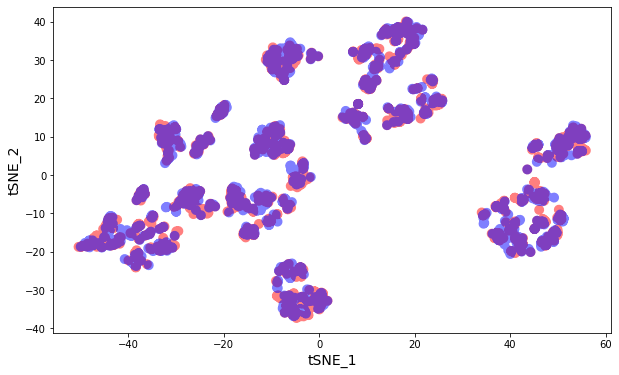

In [82]:
plt.rcParams['lines.solid_capstyle'] = 'round'
plt.rcParams['figure.figsize'] = [10, 6]

AB_data=get_coordinates(analyzed_clones, D_embedded, associated_clones_AB_down)
FMBA_data=get_coordinates(analyzed_clones, D_embedded, associated_clones_FMBA)
plt.plot(*expand(AB_data[:,0], AB_data[:,1]), lw =10, alpha=0.5, c='red')
plt.plot(*expand(FMBA_data[:,0], FMBA_data[:,1]), lw=10, alpha=0.5, c='blue')
plt.xlabel('tSNE_1', fontsize=14)
plt.ylabel('tSNE_2', fontsize=14)
plt.show()

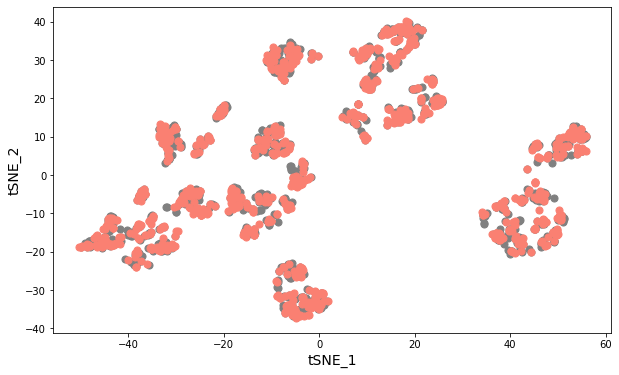

In [209]:
#AB - red
plt.rcParams['figure.figsize'] = [10, 6]

AB_data=get_coordinates(analyzed_clones, D_embedded, associated_clones_AB_down)
FMBA_data=get_coordinates(analyzed_clones, D_embedded, associated_clones_FMBA)
plt.scatter(FMBA_data[:,0], FMBA_data[:,1], s=50, c='grey', marker='o')
plt.scatter(AB_data[:,0], AB_data[:,1], s=50, c='salmon', marker='o')
plt.xlabel('tSNE_1', fontsize=14)
plt.ylabel('tSNE_2', fontsize=14)
plt.show()

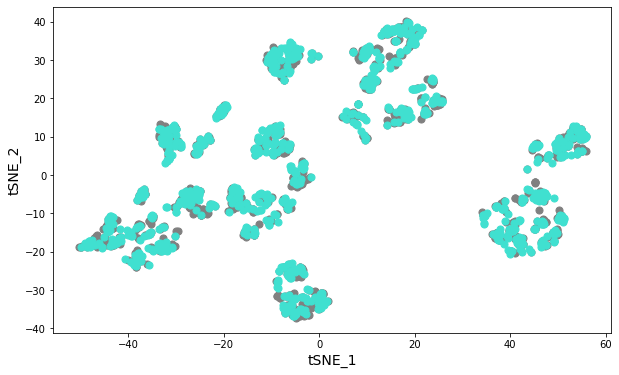

In [212]:
#FMBA - blue
plt.rcParams['figure.figsize'] = [10, 6]

AB_data=get_coordinates(analyzed_clones, D_embedded, associated_clones_AB_down)
FMBA_data=get_coordinates(analyzed_clones, D_embedded, associated_clones_FMBA)
plt.scatter(AB_data[:,0], AB_data[:,1], s=50, c='grey', marker='o')
plt.scatter(FMBA_data[:,0], FMBA_data[:,1], s=50, c='Turquoise', marker='o')
plt.xlabel('tSNE_1', fontsize=14)
plt.ylabel('tSNE_2', fontsize=14)
plt.show()


#### 1. DBSCAN

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

n_clusters_: 8
Cluster 0:167
Cluster 1:124
Cluster 2:512
Cluster 3:372
Cluster 4:102
Cluster 5:52
Cluster 6:17
Cluster 7:18


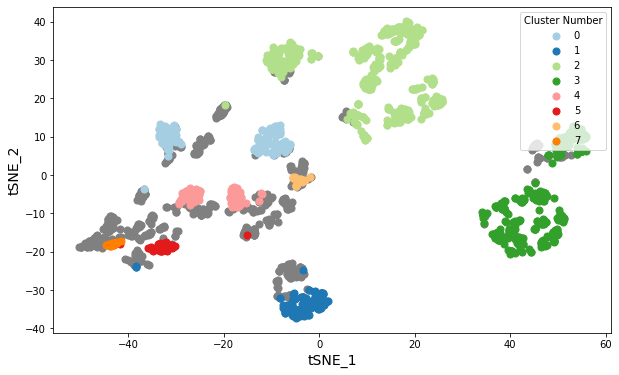

In [201]:
from sklearn.cluster import DBSCAN

plt.rcParams['figure.figsize'] = [10, 6]

def DBSCAN_Cl(eps, min_samples, distance_matrix):
    db=DBSCAN(eps=eps, min_samples=min_samples).fit(distance_matrix)
    cluster_labels=db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_=len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise_=list(cluster_labels).count(-1)
    print('n_clusters_:', n_clusters_)

    core=db.core_sample_indices_
    # get indexindexes of points in each cluster 
    #plot the results
    outliers=np.where(cluster_labels==-1)[0] # get indexes of outliers
    plt.scatter(D_embedded[outliers,0], D_embedded[outliers,1], s=50, c='grey', marker='o')


    for index_cluster in range(n_clusters_):
        cluster=np.where(cluster_labels==index_cluster)[0]
        print(f'Cluster {index_cluster}:{len(cluster)}')
        plt.scatter(D_embedded[cluster,0], D_embedded[cluster,1], s=50, c=palette[index_cluster], marker='o', label = index_cluster)
    plt.legend(loc='upper right',  numpoints=0.5, title="Cluster Number")
    plt.xlabel('tSNE_1', fontsize=14)
    plt.ylabel('tSNE_2', fontsize=14)

    plt.show()
    
DBSCAN_Cl(140, 15, distance_matrix_tcr_dist)    

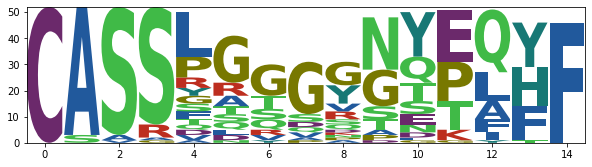

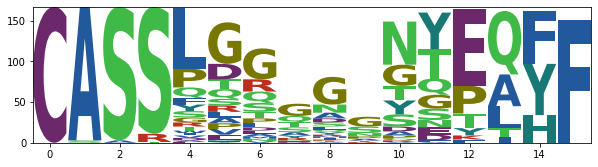

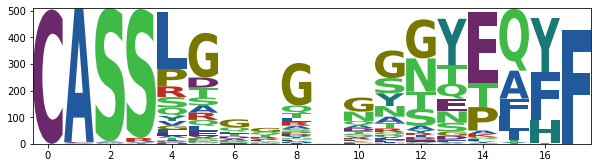

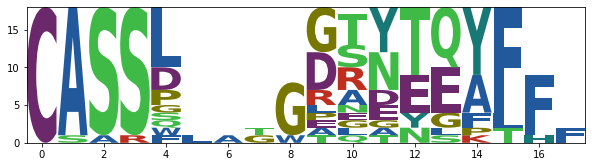

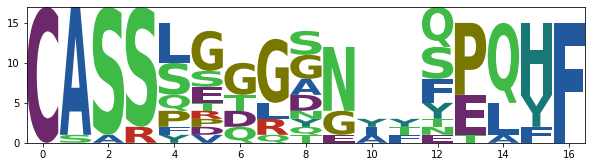

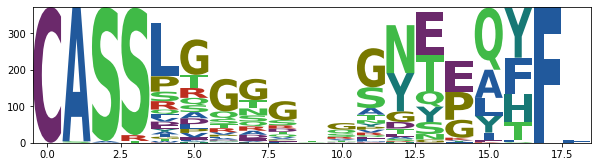

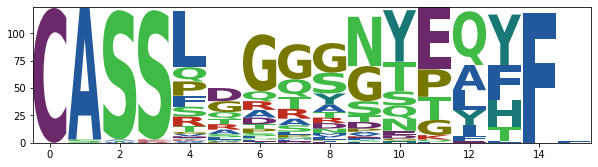

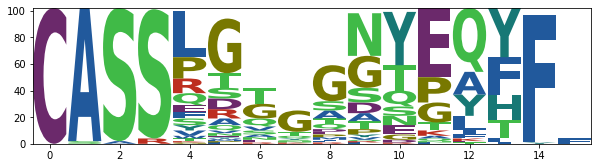

In [198]:
#Show the Logo of each cluster
def Convert_faa():
    for index_cluster in range(n_clusters_):
        cluster=np.where(cluster_labels==index_cluster)[0]
        cluster_seq=[analyzed_clones[i] for i in cluster]
        with open('Split_FASTA_Files/Cluster%i.tab' %index_cluster,"w") as tab_file:
            for i in cluster_seq:
                tab_file.write(f"{'TRB'}\t{i}" + "\n")
        records = SeqIO.parse("Split_FASTA_Files/Cluster%i.tab" %index_cluster, "tab")
        count = SeqIO.write(records, "Split_FASTA_Files/Cluster%i.fasta" %index_cluster, "fasta")
        os.remove("Split_FASTA_Files/Cluster%i.tab" %index_cluster)
#    print(f'Cluster {index_cluster}:', "converted %i records" % count)     
Convert_faa()

# Multiple sequence alignment by Clustal Omega
def ClustalO(index_cluster):
    in_file = 'Split_FASTA_Files/Cluster%d.fasta' % index_cluster
    out_file = 'Aligned_FASTA_Files/Cluster%d_Aligned.fasta' % index_cluster
    cline = ClustalOmegaCommandline(infile=in_file,
                                    outfile=out_file,
                                    verbose=True,
                                    auto=True)
    cline()
    os.remove("Split_FASTA_Files/Cluster%i.fasta" %index_cluster)


Parallel(n_jobs=os.cpu_count())(delayed(ClustalO)(index_cluster) for index_cluster in range(n_clusters_))

def Make_Logo():
    Aligned_FASTA_Files=[i for i in os.listdir('Aligned_FASTA_Files/') if i.endswith("fasta")]
    for i in range(len(Aligned_FASTA_Files)):
        with open(f'Aligned_FASTA_Files/{Aligned_FASTA_Files[i]}') as fp:
            lines = fp.readlines()  
            seqs = [seq.strip().upper() for seq in lines if ('#' not in seq) and ('>') not in seq]
            ww_counts_df = lm.alignment_to_matrix(sequences=seqs, to_type='counts', characters_to_ignore='.-X')
            crp_logo=lm.Logo(ww_counts_df, color_scheme='NajafabadiEtAl2017')
            os.remove(f'Aligned_FASTA_Files/{Aligned_FASTA_Files[i]}') 
            
Make_Logo()

def Make_Logo_one_out():
    Aligned_FASTA_Files=[i for i in os.listdir('Aligned_FASTA_Files/') if i.endswith("fasta")]
    n=0
    for i in range(len(Aligned_FASTA_Files)):
        with open(f'Aligned_FASTA_Files/{Aligned_FASTA_Files[i]}') as fp:
            lines = fp.readlines()  
            seqs = [seq.strip().upper() for seq in lines if ('#' not in seq) and ('>') not in seq]
            ww_counts_df = lm.alignment_to_matrix(sequences=seqs, to_type='counts', characters_to_ignore='.-X')
            ax = plt.subplot2grid((15,6),(n,2),colspan = 2)
            n+=2
            crp_logo=lm.Logo(ww_counts_df, color_scheme='NajafabadiEtAl2017', ax=ax, show_spines=False)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title('Cluster %i' %i, loc='left')


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

n_clusters_: 8
167
124
512
372
102
52
17
18


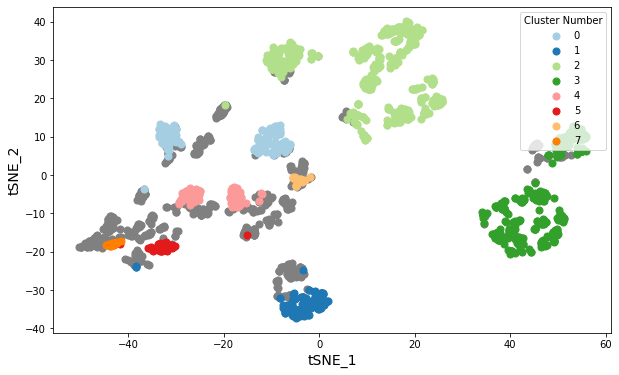

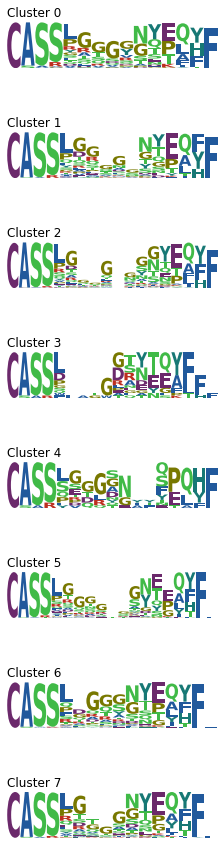

In [200]:
plt.rcParams['figure.figsize'] = [10, 6]

DBSCAN_Cl(140, 15, distance_matrix_tcr_dist)    

Convert_faa()

Parallel(n_jobs=os.cpu_count())(delayed(ClustalO)(index_cluster) for index_cluster in range(n_clusters_))

plt.rcParams['figure.figsize'] = [12, 15]

Make_Logo_one_out()